Files already downloaded and verified
Files already downloaded and verified


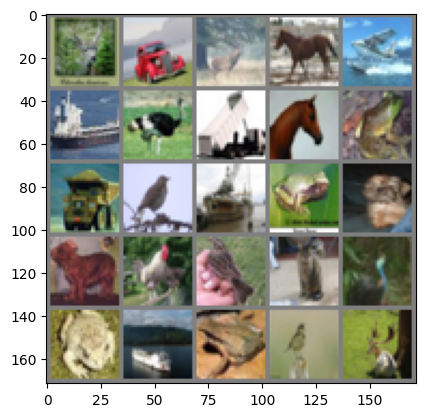

In [1]:
"""
CNN
    -> Convolution layers
    -> MaxPooling
    -> Save/Load model
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# dataset has PILImage images of range [0,1].
# We transform them to Tensors of normalized range [-1,1] 
#   -> Standardization (Z-Score Normalization) -> x_new = (x-mean)/sd

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data_cnn',
                                             train=True,
                                             download=True,
                                             transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root="./data_cnn",
                                            train=False,
                                            download=True,
                                            transform=transform)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

classes = ('plane','car','bird','cat','deer',
           'dog','frog','horse','ship','truck',)

def imshow(imgs):
    imgs = imgs / 2 + 0.5 # unnormalize -> onlu make the original image look bright
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs,(1,2,0)))
    plt.show()
    
# one batch of random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
imshow(img_grid)


In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,32,3) #input channel, output channel, kernel size
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,64,3)
        self.fc1 = nn.Linear(64*4*4, 64)
        self.fc2 = nn.Linear(64,10)
        
    def forward(self, x):
        # N, 3, 32, 32
        x = F.relu(self.conv1(x)) # -> N, 32, 30, 30
        x = self.pool(x)          # -> N, 32, 15, 15
        x = F.relu(self.conv2(x)) # -> N, 64, 13, 13
        x = self.pool(x)          # -> N, 64, 6, 6
        x = F.relu(self.conv3(x)) # -> N, 64, 4, 4
        x = torch.flatten(x,1)    # -> N, 1024
        x = F.relu(self.fc1(x))   # -> N, 64
        x = self.fc2(x)           # -> N, 10
        
        return x

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

# loop over the dataset multiple times
for epoch in range(num_epochs):
    
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        
        images,labels = images.to(device), labels.to(device)


        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()

    print('[{}] Loss: {:.3f}'.format(epoch + 1,running_loss/n_total_steps)) # average loss for each epoch

print('Finished Training')
PATH = "./models/cnn.pth"
torch.save(model.state_dict(), PATH) # state_dict = convert model to dictionary of paremeters


[1] Loss: 1.479
[2] Loss: 1.124
[3] Loss: 0.957
[4] Loss: 0.847
[5] Loss: 0.771
[6] Loss: 0.714
[7] Loss: 0.664
[8] Loss: 0.621
[9] Loss: 0.582
[10] Loss: 0.550
Finished Training


In [7]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH))
loaded_model.to(device=device)
loaded_model.eval() 

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_loader.dataset)
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) # model from the previous cell
        
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()
        
        
        outputs2 = loaded_model(images) # model from load model
        _, predicted2 = torch.max(outputs2, 1)
        n_correct2 += (predicted2 == labels).sum().item() 
        
    acc = 100.0 * (n_correct / n_samples)
    print(f"Accuracy of the model: {acc} %")
    
    acc = 100.0 * (n_correct2 / n_samples)
    print(f"Accuracy of the model: {acc} %")

Accuracy of the model: 72.19 %
Accuracy of the model: 72.19 %
